In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install pyvi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 40.9 MB/s eta 0:00:00


# **Khai báo thư viện**

In [3]:
import numpy as py
import pandas as pd
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding, Dense, Dropout, LSTM, GRU, Input, GlobalMaxPooling1D, LayerNormalization
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras. preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from pyvi import ViTokenizer
from pyvi import ViUtils

#**Đọc và tiền xử lý dữ liệu**

In [57]:
data = pd. read_excel("/content/drive/MyDrive/Colab Notebooks/Nhóm 12 - Phân tích cảm xúc trên trang tinhte.vn/DATA/Datacomment_sentiment.xlsx")
print("Thống kê bộ dữ liệu: ");
print("Số dòng dữ liệu là: ", data.shape[0])
print("Số cột dữ liệu là: ", data.shape[1])
data.head(10)


Thống kê bộ dữ liệu: 
Số dòng dữ liệu là:  2988
Số cột dữ liệu là:  2


,Comment,Label
0,"Không nên mua chuột cua Logitech , vì dùng nó ...",Pos
1,Nói thiệt là mình thì thì chuột nào mình cũng ...,Neg
2,Xai chuot so nhat bi double click .,Neu
3,Cơ bản là thiết kế ôm chuột chưa đã Như hiện g...,Pos
4,Đang dùng mx 1 . Cũng ngon nhưng chưa đầy năm ...,Neg
5,mình chưa được đụng tới con đời 1 nữa,Neu
6,"Chưa thấy đc điểm thuyết phục để mua , nhất là...",Neg
7,Mình xài chuột mit sứ nhỏ cổng giá 25k/con .,Neu
8,Đang dùng con TT Esport Level 10M mà cầm sang ...,Pos
9,"Vừa sắm em M905 , thấy nói ngon nhưng mới xài ...",Pos


In [58]:
print("Thông tin bộ dữ liệu là: ", data.shape)
negative_count = len(data[data['Label'] == 'Neg'])
print("Số lượng nhãn Negative là:", negative_count)

positive_count = len(data[data['Label'] == 'Pos'])
print("Số lượng nhãn Positive là:", positive_count)

neutral_count = len(data[data['Label'] == 'Neu'])
print("Số lượng nhãn Neutral là:", neutral_count)

print("Kiểu dữ liệu của các thuộc tính:\n", data.dtypes )

Thông tin bộ dữ liệu là:  (2988, 2)
Số lượng nhãn Negative là: 1033
Số lượng nhãn Positive là: 1003
Số lượng nhãn Neutral là: 950
Kiểu dữ liệu của các thuộc tính:
 Comment    object
Label      object
dtype: object


In [59]:
#Xác định lại các thuộc tính trong bộ dữ liệu
sentiment_data = pd.DataFrame({'input':data['Comment'], 'label':data['Label']})
sentiment_data = sentiment_data.dropna()
sentiment_data = sentiment_data.reset_index(drop=True)
#xóa dữ liệu trùng lặp
sentiment_data.drop_duplicates()
print(sentiment_data.shape)
#Hiển thị 5 dòng dữ liệu đầu
sentiment_data.head()

(2986, 2)


,input,label
0,"Không nên mua chuột cua Logitech , vì dùng nó ...",Pos
1,Nói thiệt là mình thì thì chuột nào mình cũng ...,Neg
2,Xai chuot so nhat bi double click .,Neu
3,Cơ bản là thiết kế ôm chuột chưa đã Như hiện g...,Pos
4,Đang dùng mx 1 . Cũng ngon nhưng chưa đầy năm ...,Neg


# **Khởi tạo dữ liệu đầu vào**

In [60]:
#Khởi tạo dữ liệu đầu vào và nhãn đầu vào
input_data = sentiment_data['input'].values
input_label = sentiment_data['label'].values

# Từ điển các nhãn
label_dict = {'Neg':0,'Pos':1, 'Neu': 2}

#Khởi tạo các danh sách
input_pre = []
label_with_accent = []

#Vòng lặp tiền xử lý
for idx, dt in enumerate(input_data):
  #input_text_pre = list(tf.keras.preprocessing.text.text_to_word_sequence(dt))
  input_text_pre = list(tf.keras.preprocessing.text.text_to_word_sequence(str(dt)))
  input_text_pre = " ".join(input_text_pre)
  #Xóa dấu câu
  input_text_pre_no_accent = str(ViUtils.remove_accents(input_text_pre).decode("utf-8"))
  #tokenize câu ra (liên kết các từ có ý nghĩa)
  input_text_pre_accent = ViTokenizer.tokenize(input_text_pre)
  input_text_pre_no_accent = ViTokenizer.tokenize(input_text_pre_no_accent)
  input_pre.append(input_text_pre_accent)
  input_pre.append(input_text_pre_no_accent)
  label_with_accent.append(input_label[idx])
  label_with_accent.append(input_label[idx])

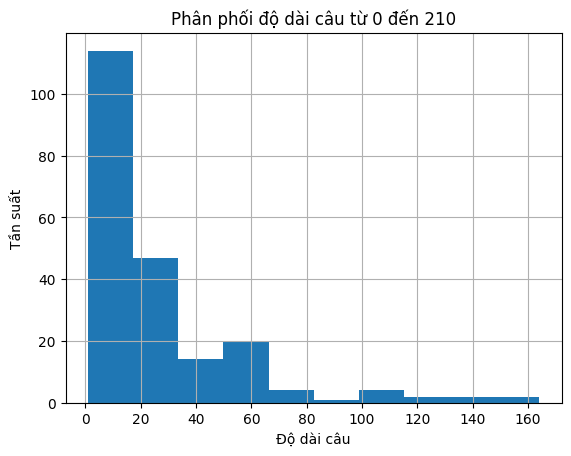

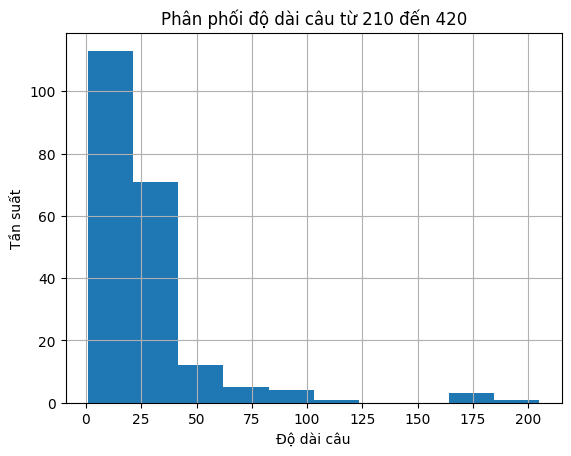

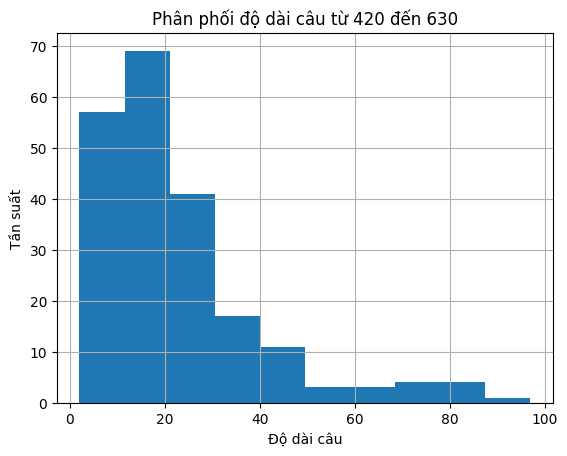

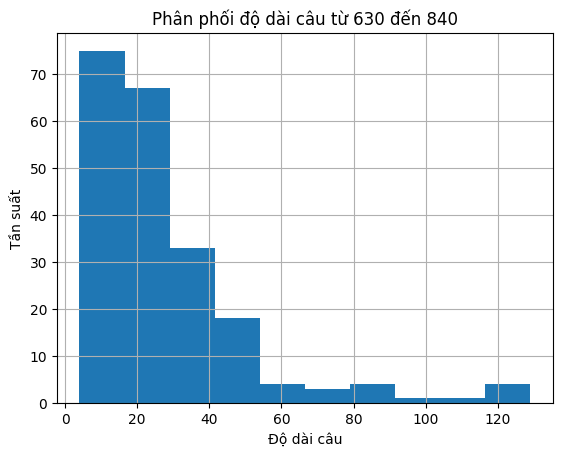

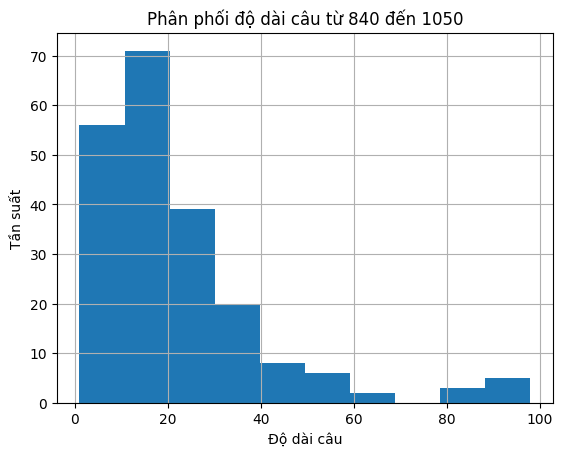

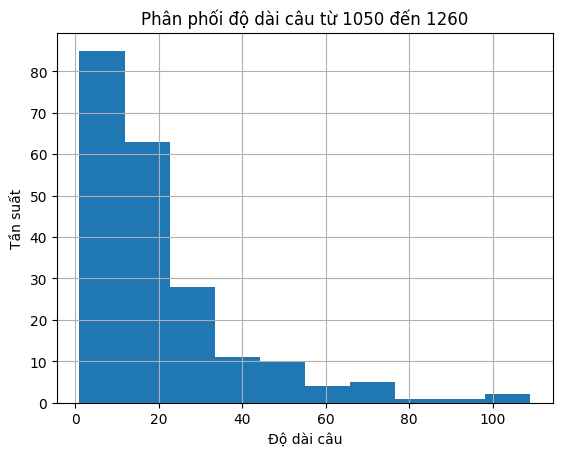

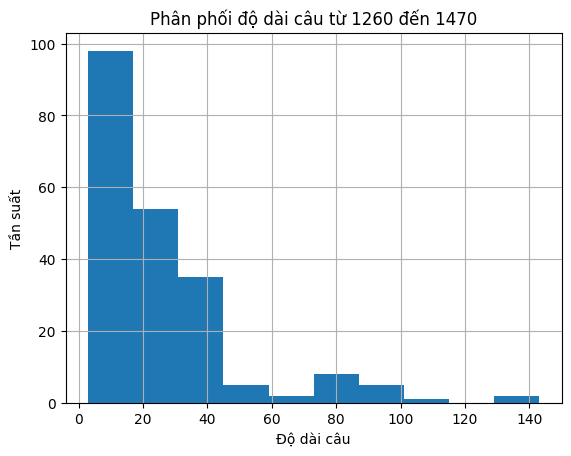

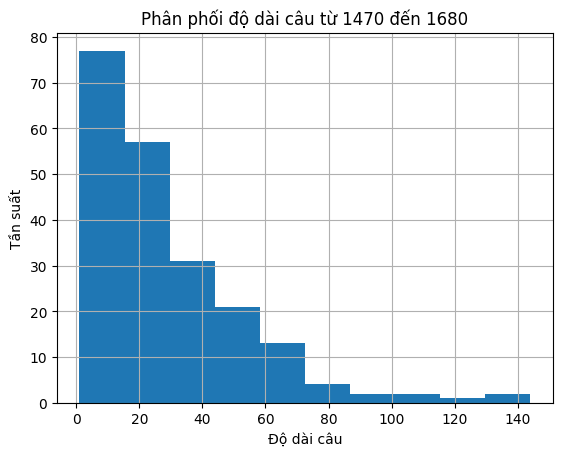

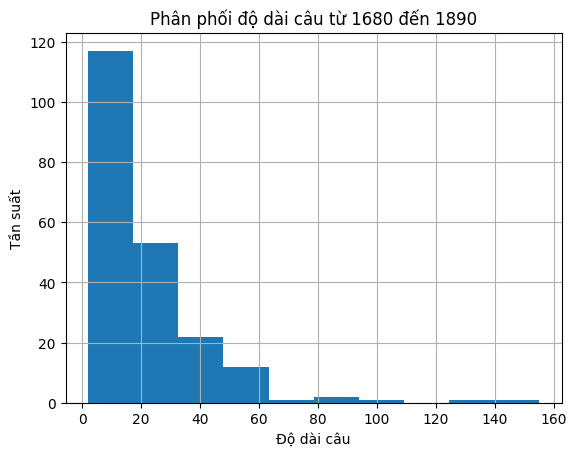

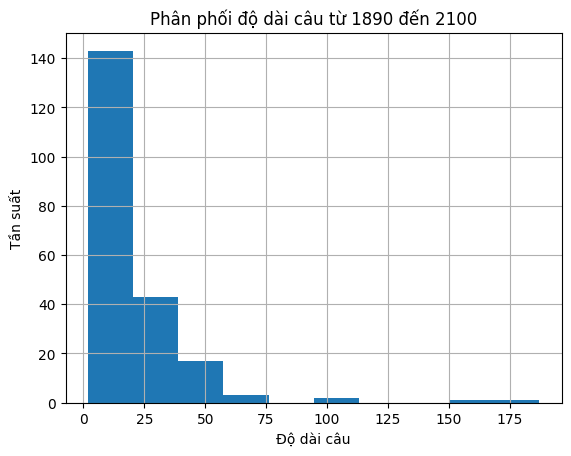

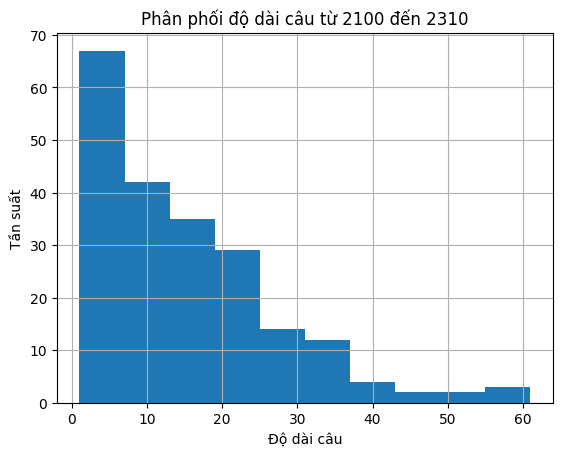

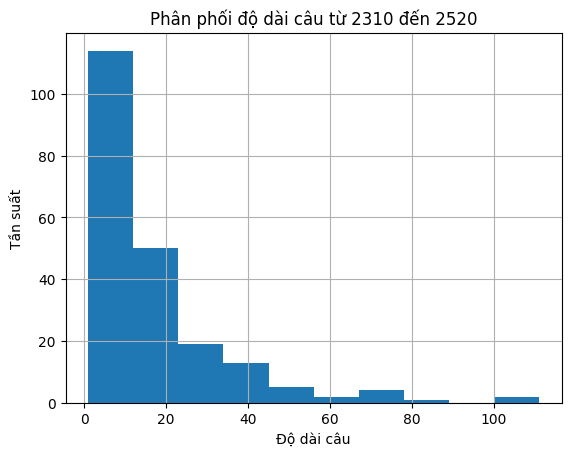

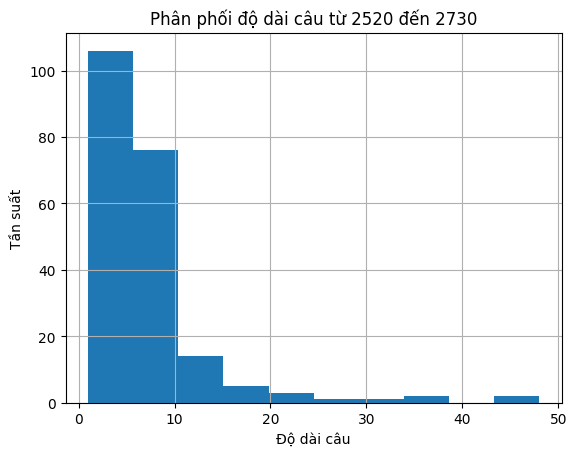

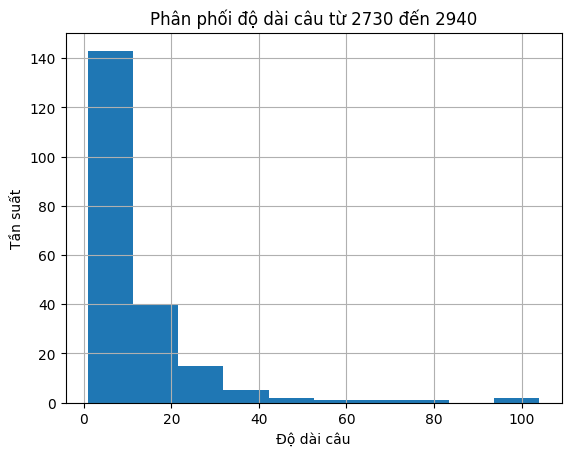

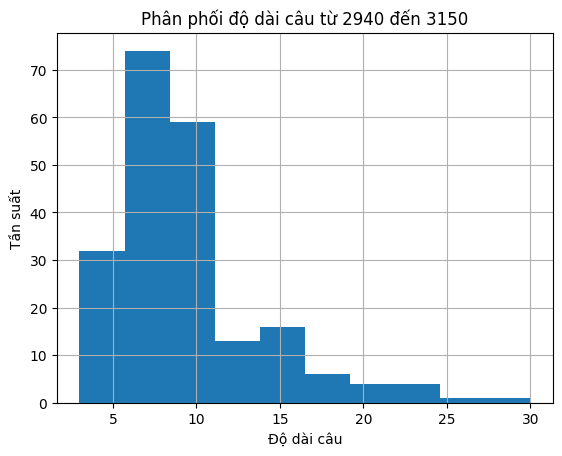

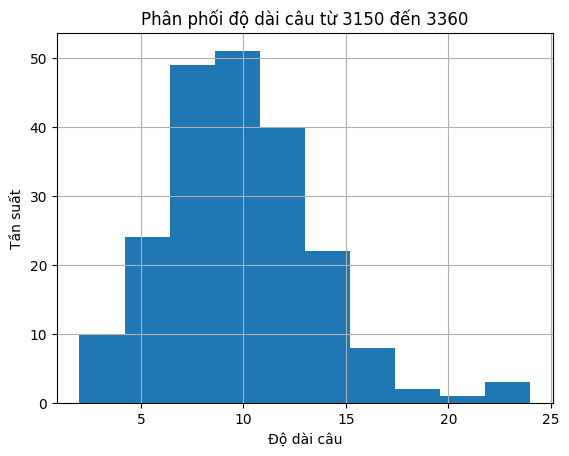

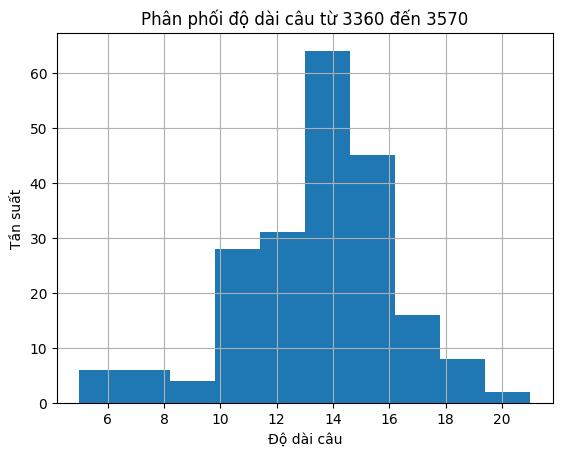

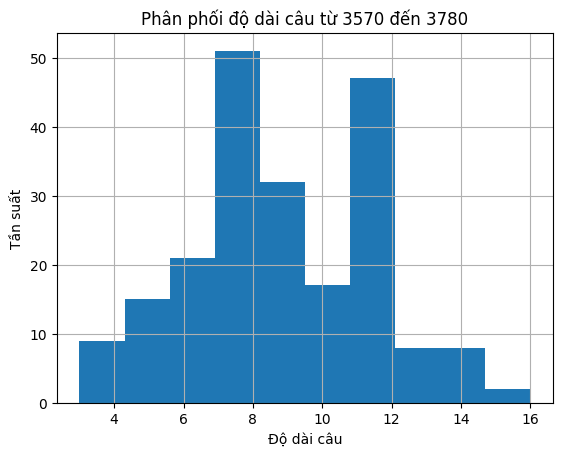

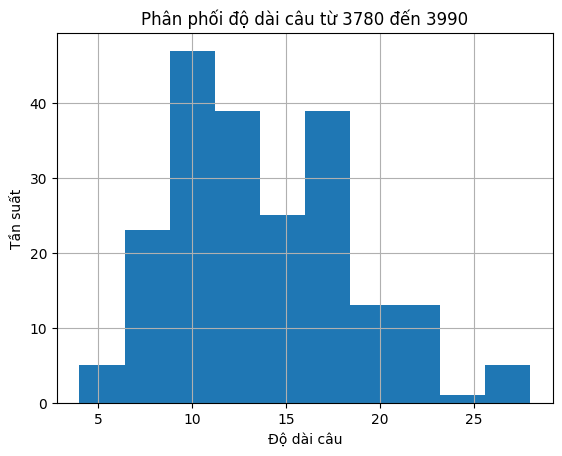

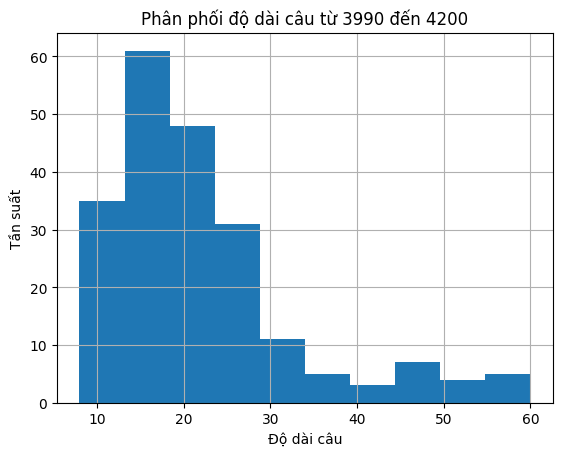

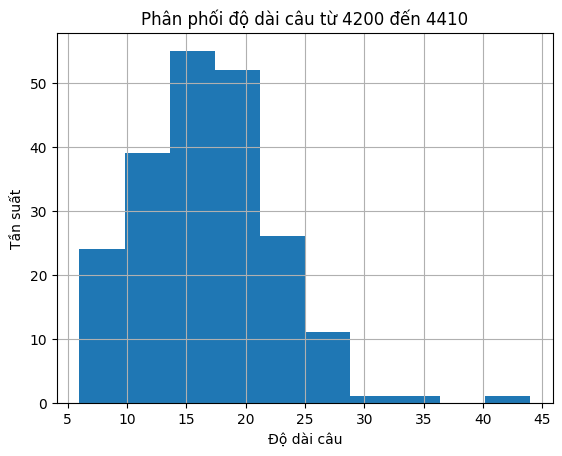

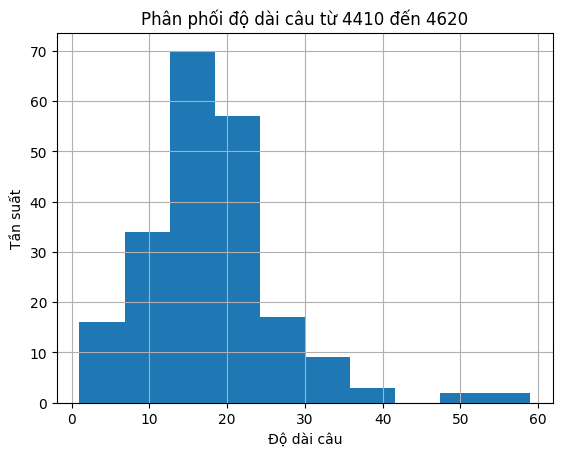

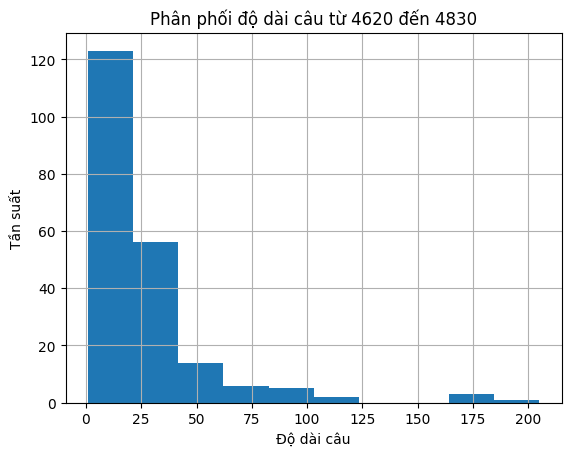

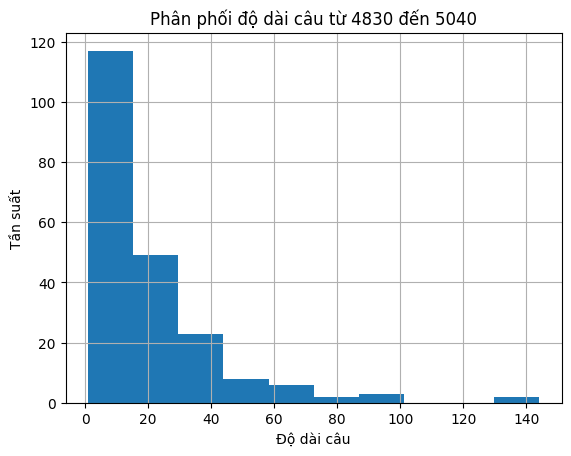

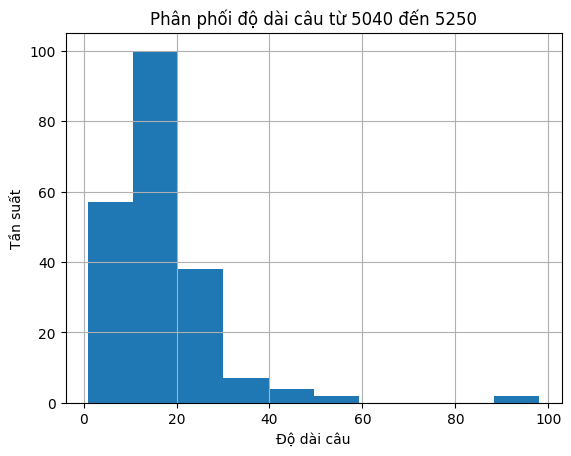

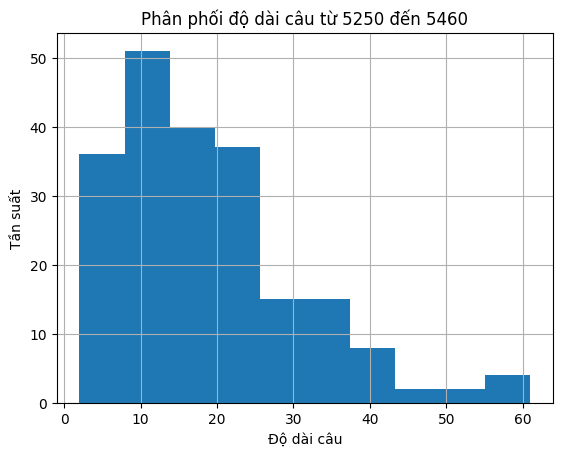

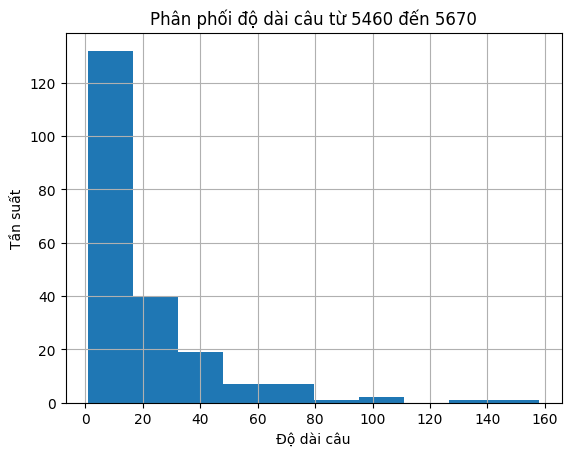

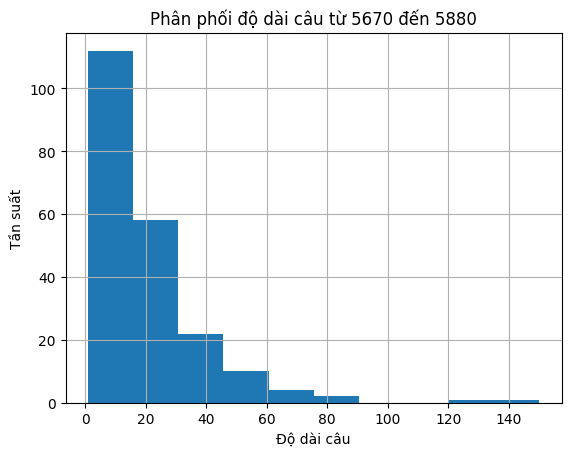

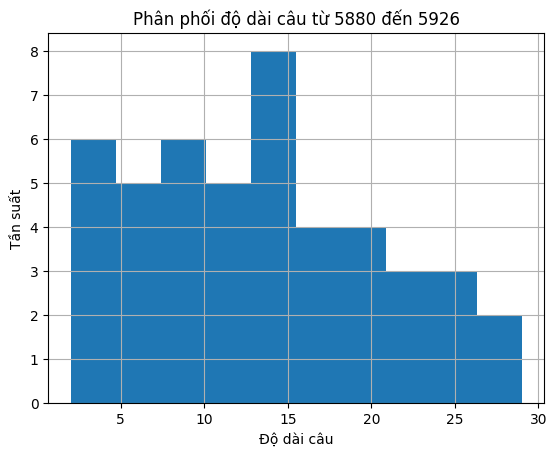

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

# Tạo biểu đồ histogram cho mỗi tập hợp con của `input_pre`
def plot_histogram(data, start, end, bins=10):
    seq_len = [len(i.split()) for i in data[start:end]]
    pd.Series(seq_len).hist(bins=bins)
    plt.xlabel('Độ dài câu')
    plt.ylabel('Tần suất')
    plt.title(f'Phân phối độ dài câu từ {start} đến {end}')
    plt.show()

# Tổng số phần tử trong `input_pre`
total_length = len(input_pre)

# Số phần tử mỗi biểu đồ sẽ hiển thị
batch_size = 210

# Vòng lặp để tạo biểu đồ histogram
for start in range(0, total_length, batch_size):
    end = min(start + batch_size, total_length)
    plot_histogram(input_pre, start, end)


Từ biểu đồ trên ta thấy trung bình 1 comment sẽ có khoảng 40 ký tự

# **Khởi tạo Tokennizer và mã hóa văn bản**

In [61]:
# Chuyển đổi tokenizer bộ dữ liệu và lưu vào file
#Chuyển đổi các nhãn thành các số nguyên 0, 1, 2 theo từ điển nhãn
label_idx = [label_dict[i] for i in label_with_accent]
#Chuyển đổi các nhãn số nguyên thành dạng one-hot encoding của Keras với 3 lớp (Neg, Pos, Neu)
label_tf = tf.keras.utils.to_categorical(label_idx, num_classes=3, dtype='float32')

# khởi tạo một đối tượng tokenizer_data từ lớp Tokenizer trong Keras để mã hóa
# và chuyển đổi dữ liệu văn bản thành chuỗi số nguyên.
tokenizer_data = Tokenizer(oov_token='<OOV>', filters = '', split = ' ')

# sử dụng phương thức fit_on_texts() của tokenizer_data để thực hiện mã hóa từ vựng và xây dựng từ điển từ dữ liệu input_pre. Điều này giúp xác định
# các từ duy nhất và gán một số nguyên duy nhất cho mỗi từ.
tokenizer_data.fit_on_texts(input_pre)

# sử dụng phương thức texts_to_sequences() của tokenizer_data để chuyển đổi
# dữ liệu văn bản input_pre thành các chuỗi số nguyên tương ứng với từng
# từ trong từ điển
tokenizer_data_text = tokenizer_data.texts_to_sequences(input_pre)

# sử dụng hàm pad_sequences() để đệm các chuỗi số nguyên trong  tokenizer_data_text thành cùng một độ dài (maxlen = 40).
# Điều này đảm bảo rằng các chuỗi đầu vào có cùng kích thước
vec_data = pad_sequences(tokenizer_data_text, padding='post', maxlen = 40)

#Lưu Tokenize (reuse trong tương lai - chứa thông tin vocabulary)
pickle.dump(tokenizer_data, open("tokenizer_data.pkl", "wb"))
with open("/content/drive/MyDrive/tokenizer_data.pkl", "wb") as file:
    pickle.dump(tokenizer_data, file)

print("input data.shape", vec_data.shape)
data_vocab_size = len(tokenizer_data.word_index)+1
print("data_vocab_size: ", data_vocab_size)

input data.shape (5972, 40)
data_vocab_size:  5826


In [62]:
# Chia tập dữ liệu thành 3 phần train, val, test
#lấy 80% chia cho tập train, 20 % chia cho tập test, sau đó lấy 80% tập train chia 10% cho tập test
X_train, X_val, y_train, y_val = train_test_split(vec_data, label_tf, test_size=0.2, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state = 42)

X_train, X_test, y_train, y_test = train_test_split(vec_data, label_tf, test_size=0.1, random_state = 42)
print("Training sample: ", len(X_train))
print("Validation sample: ", len(X_val))
print("Test sample: ", len(X_test))

Training sample:  5374
Validation sample:  1195
Test sample:  598


# **Xây dựng mô hình CNN-BiLSMT**

In [19]:
from keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Bidirectional, LSTM
from keras.models import Model
from keras.optimizers import Adam

In [63]:
def generate_model():
  # khai báo ngưỡng dropout, đại diện cho tỷ lệ các đơn vị bị bỏ qua
  # trong quá trình huấn luyện để tránh việc quá khớp (overfitting)
  dropout_threshold = 0.3

  # gán kích thước của từ điển từ dữ liệu cho biến input_dim
  input_dim = data_vocab_size

  # gán kích thước đầu ra của lớp nhúng (embedding) cho biến output_dim.
  # Trong trường hợp này, các từ sẽ được biểu diễn bằng một vector 32 chiều.
  output_dim = 32

  # gán độ dài đầu vào cho biến input_length. đảm bảo rằng độ dài của các chuỗi
  # đầu vào sẽ được đệm (padding) hoặc cắt (truncation) để có cùng kích thước
  input_length = 40

  # khởi tạo một đối tượng GlorotNormal từ module initializers trong
  # thư viện Keras để sử dụng làm trình khởi tạo trọng số cho mạng nơ-ron.
  initializer = tf.keras.initializers.GlorotNormal()

  # khai báo lớp đầu vào với kích thước đầu vào là input_length
  input_layer = Input(shape=input_length)

  # thực hiện lớp nhúng (embedding) ánh xạ các từ sang các vector dựa trên
  # input_dim và output_dim. embeddings_initializer được sử dụng để khởi tạo
  # ma trận trọng số của lớp nhúng
  feature = Embedding(input_dim=input_dim, output_dim=output_dim,
                      input_length=input_length,
                      embeddings_initializer="GlorotNormal")(input_layer)

  # Sử dụng mạng nơ ron tích chập trích xuất các đặc trưng từ đầu vào đã nhúng.
  # Các lớp này được sử dụng để tạo một đặc trưng từ ngữ cảnh và cấu trúc của câu
  cnn_feature = Conv1D(filters=32, kernel_size=3, padding='same',
                       activation='relu')(feature)
  cnn_feature = MaxPooling1D()(cnn_feature)
  cnn_feature = Dropout(dropout_threshold)(cnn_feature)
  cnn_feature = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(cnn_feature)
  cnn_feature = MaxPooling1D()(cnn_feature)
  cnn_feature = LayerNormalization()(cnn_feature)
  cnn_feature = Dropout(dropout_threshold)(cnn_feature)


#Kết hợp giữa LSTM hai chiều và GRU hai chiều, áp dụng thêm Dropout giữa các lớp, làm cho mô hình này phức tạp hơn và có khả năng giảm overfitting nhờ Dropout.
  bi_lstm_feature = Bidirectional(LSTM(units=32, dropout=dropout_threshold, return_sequences=True, kernel_initializer=initializer))(feature)
  bi_lstm_feature = MaxPooling1D()(bi_lstm_feature)
  bi_lstm_feature = Dropout(dropout_threshold)(bi_lstm_feature)
  bi_lstm_feature = Bidirectional(GRU(units=64, dropout=dropout_threshold, return_sequences=True, kernel_initializer=initializer))(bi_lstm_feature)
  bi_lstm_feature = MaxPooling1D()(bi_lstm_feature)
  bi_lstm_feature = LayerNormalization()(bi_lstm_feature)


  # kết hợp hai tập đặc trưng từ các lớp tích chập và LSTM thành
  # một tập đặc trưng duy nhất bằng cách kết hợp chúng theo chiều thứ hai.
  combine_feature = tf.keras.layers.Concatenate()([cnn_feature, bi_lstm_feature])
  combine_feature = GlobalMaxPooling1D()(combine_feature)
  combine_feature = LayerNormalization()(combine_feature)

  # chuỗi các lớp mạng nơ-ron tiếp theo để xử lý tập đặc trưng đã kết hợp.
  # Các lớp này thực hiện các phép biến đổi phi tuyến để tạo ra dự đoán cuối cùng.
  classifier = Dense(90, activation = 'relu')(combine_feature)
  classifier = Dropout(0.3)(classifier)
  classifier = Dense(70, activation = 'relu')(classifier)
  classifier = Dropout(0.3)(classifier)
  classifier = Dense(50, activation = 'relu')(classifier)
  classifier = Dropout(0.3)(classifier)
  classifier = Dense(30, activation = 'relu')(classifier)
  classifier = Dropout(0.3)(classifier)
  classifier = Dense(3, activation = 'softmax')(classifier)

  model = tf.keras.Model(inputs = input_layer, outputs= classifier)

  return model

model = generate_model()
adam = Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 40)]                 0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 40, 32)               186432    ['input_3[0][0]']             
                                                                                                  
 conv1d_4 (Conv1D)           (None, 40, 32)               3104      ['embedding_2[0][0]']         
                                                                                                  
 max_pooling1d_8 (MaxPoolin  (None, 20, 32)               0         ['conv1d_4[0][0]']            
 g1D)                                                                                       

# Biểu diễn model

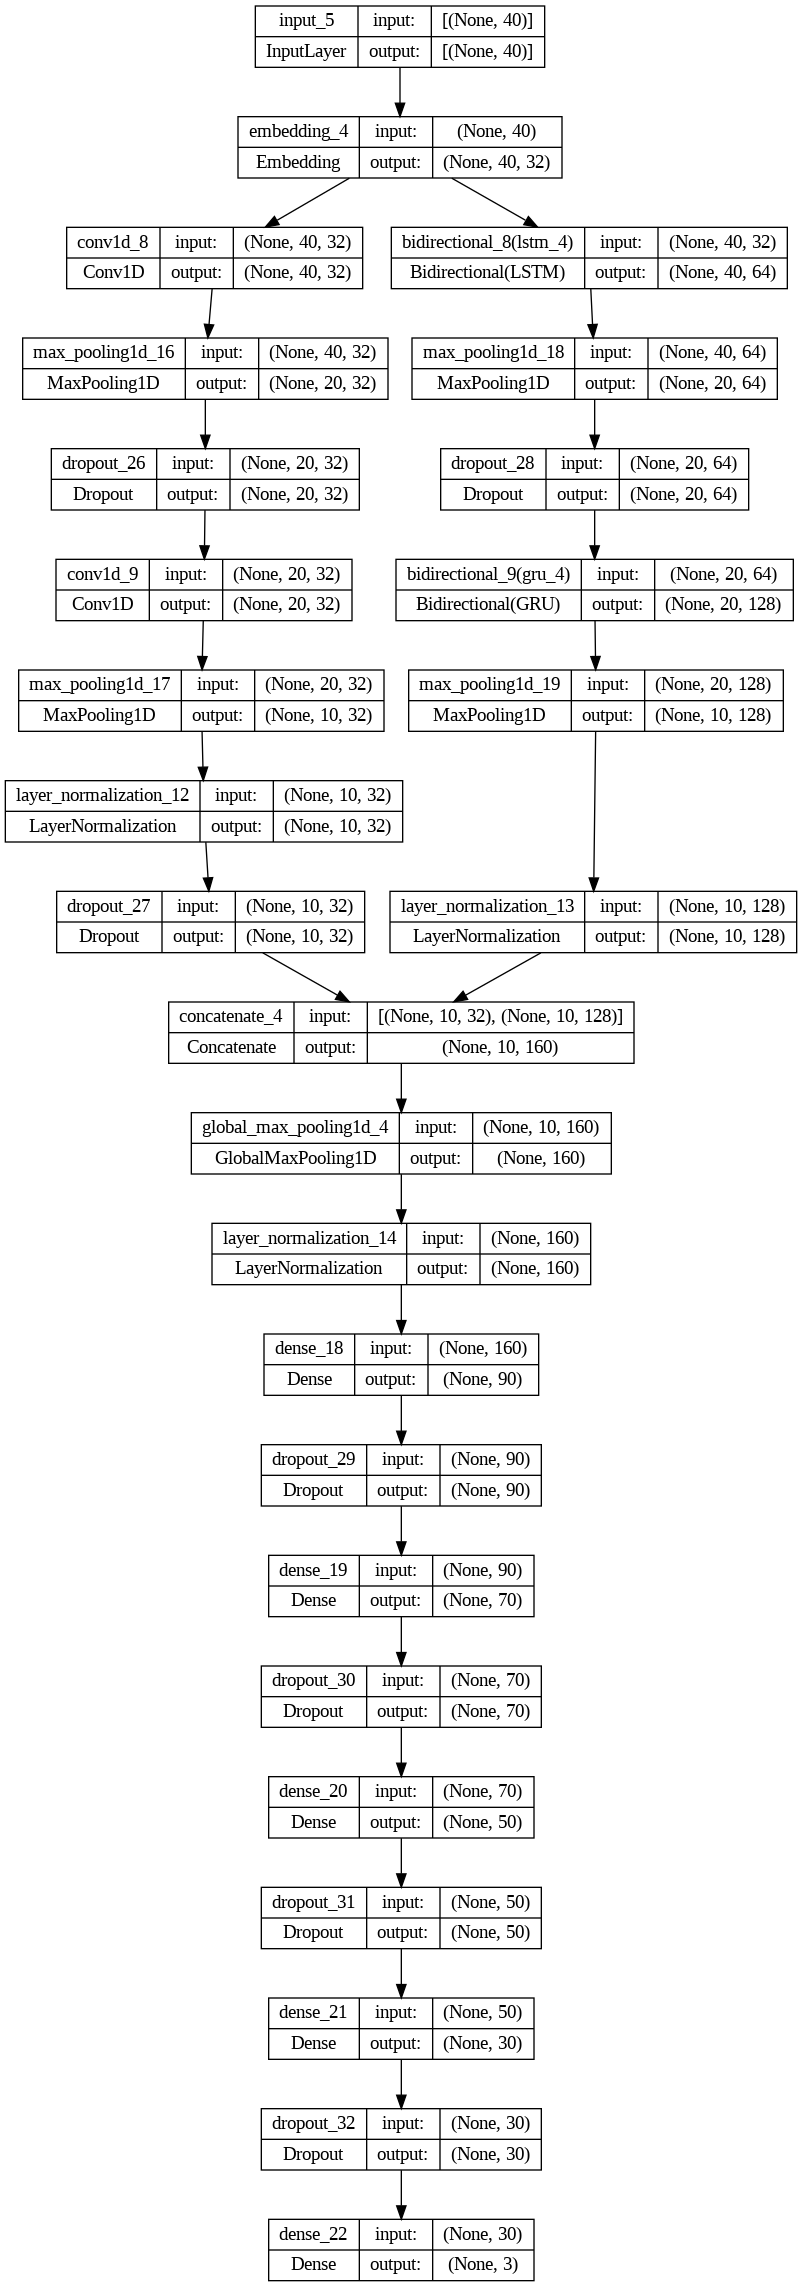

In [ ]:
dot_img_file = 'model_visualize.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [64]:
# Huấn luyện mô hình máy học sử dụng mạng CNN-BiLSTM trên dữ liệu huấn luyện và dữ liệu kiểm tra (validation)
#ModelCheckpoint nhằm lưu lại mô hình tại thời điểm có giá trị mất mát trên tập validation thấp nhất
callback_model = tf.keras.callbacks.ModelCheckpoint('model_cnn_bilstm.h5', monitor='val_loss')
#Khai báo sử dụng call back để lưu mô hình tốt nhất, epoch là số lần mà toàn bộ tập dữ liệu huấn luyện được truyền qua mô hình
#Batchsize là số lượng mẫu dữ liệu được xử lý trước khi mô hình cập nhật trọng số
history = model.fit(x = X_train, y = y_train, validation_data = (X_val, y_val), epochs = 65, batch_size = 128, callbacks=[callback_model])

Epoch 1/65
42/42 [==============================] - 23s 239ms/step - loss: 1.1369 - accuracy: 0.3277 - val_loss: 1.0977 - val_accuracy: 0.3515
Epoch 2/65


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


42/42 [==============================] - 8s 188ms/step - loss: 1.1029 - accuracy: 0.3361 - val_loss: 1.0964 - val_accuracy: 0.3866
Epoch 3/65
42/42 [==============================] - 9s 215ms/step - loss: 1.0988 - accuracy: 0.3437 - val_loss: 1.0972 - val_accuracy: 0.3707
Epoch 4/65
42/42 [==============================] - 7s 158ms/step - loss: 1.1009 - accuracy: 0.3389 - val_loss: 1.0974 - val_accuracy: 0.3490
Epoch 5/65
42/42 [==============================] - 10s 235ms/step - loss: 1.0999 - accuracy: 0.3403 - val_loss: 1.0976 - val_accuracy: 0.3941
Epoch 6/65
42/42 [==============================] - 7s 162ms/step - loss: 1.0990 - accuracy: 0.3402 - val_loss: 1.0973 - val_accuracy: 0.3364
Epoch 7/65
42/42 [==============================] - 9s 226ms/step - loss: 1.0985 - accuracy: 0.3396 - val_loss: 1.0962 - val_accuracy: 0.3573
Epoch 8/65
42/42 [==============================] - 7s 157ms/step - loss: 1.0976 - accuracy: 0.3403 - val_loss: 1.0931 - val_accuracy: 0.4008
Epoch 9/65
42/42

In [65]:
# Kiểm tra độ chính xác của mô hình trên tập test
model.load_weights("model_cnn_bilstm.h5")
model.evaluate(X_test,y_test)

19/19 [==============================] - 0s 21ms/step - loss: 1.7128 - accuracy: 0.8562


[1.7128241062164307, 0.8561872839927673]

## Dự đoán mô hình trên tập validation

In [66]:
labels = ["Neg","Pos", "Neu"]
y_pred = model.predict(X_val)  # Dự đoán trên tập validation


38/38 [==============================] - 3s 18ms/step


In [67]:
import numpy as np

y_pred = [labels[np.argmax(pred)] for pred in y_pred]
y_true = [labels[np.argmax(true)] for true in y_val]  # Nhãn thực tế trên tập validation

In [68]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred, zero_division=1)
print(report)

              precision    recall  f1-score   support

         Neg       0.93      0.95      0.94       427
         Neu       0.90      0.91      0.91       356
         Pos       0.94      0.93      0.94       412

    accuracy                           0.93      1195
   macro avg       0.93      0.93      0.93      1195
weighted avg       0.93      0.93      0.93      1195



## Dự đoán mô hình trên tập test

In [69]:
y_pred = model.predict(X_test)  # Dự đoán trên tập test

19/19 [==============================] - 1s 30ms/step


In [70]:
import numpy as np

y_pred = [labels[np.argmax(pred)] for pred in y_pred]
y_true = [labels[np.argmax(true)] for true in y_test]  # Nhãn thực tế trên tập validation

In [71]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred, zero_division=1)
print(report)

              precision    recall  f1-score   support

         Neg       0.87      0.89      0.88       210
         Neu       0.81      0.82      0.82       181
         Pos       0.89      0.86      0.87       207

    accuracy                           0.86       598
   macro avg       0.85      0.85      0.85       598
weighted avg       0.86      0.86      0.86       598



In [72]:
def preprocess_raw_input(raw_input, tokenizer):
  input_text_pre = list(tf.keras.preprocessing.text.text_to_word_sequence(raw_input))
  input_text_pre = " ".join(input_text_pre)
  input_text_pre_accent = ViTokenizer.tokenize(input_text_pre)
  print("Text preprocessed: ", input_text_pre_accent)
  tokenized_data_text = tokenizer.texts_to_sequences([input_text_pre_accent])
  vec_data = pad_sequences(tokenized_data_text, padding='post', maxlen=40)
  return vec_data

def inference_model(input_feature, model):
  output = model(input_feature).numpy()[0]
  result = output.argmax()
  conf = float(output.max())
  label_dict = {'Tiêu cực':0, 'Tích cực':1, 'Trung lập':2}
  label = list(label_dict.keys())
  return label[int(result)], conf

def prediction(raw_input, tokenizer, model):
  input_model = preprocess_raw_input(raw_input, tokenizer_data)
  result, conf = inference_model(input_model, model)

  return result, conf

my_model = generate_model()
my_model = load_model('model_cnn_bilstm.h5')

with open(r"tokenizer_data.pkl", "rb") as input_file:
  my_tokenizer = pickle.load(input_file)

print(prediction("Ứng dụng bình thường", my_tokenizer, my_model))

Text preprocessed:  ứng_dụng bình_thường
('Trung lập', 1.0)


In [75]:
# vòng lặp vô hạn để kiểm thử mô hình phân loại dựa vào đầu vào từ
# người dùng qua dòng lệnh. Người dùng sẽ nhập các đoạn văn bản để mô hình
# dự đoán lớp (sentiment) tương ứng cho mỗi đoạn văn bản đó.
# Người dùng có thể nhập "end" để kết thúc vòng lặp và thoát khỏi chương trình
while(True):
  text = input()
  if text == "end":
    break
  else:
    print(prediction(text, my_tokenizer, my_model)[0] + "\n")

App này xịn vậy 
Text preprocessed:  app này xịn_vậy
Tích cực

Thiết kế máy này quá đẹp mà còn rẻ nữa 
Text preprocessed:  thiết_kế máy này quá đẹp mà còn rẻ nữa
Trung lập

Quá đẹp
Text preprocessed:  quá đẹp
Tích cực

Nên mua nha
Text preprocessed:  nên mua nha
Trung lập

Giao diện đẹp, rẻ, tuyệt vời
Text preprocessed:  giao_diện đẹp rẻ tuyệt_vời
Tích cực

Xấu quá, dùng mấy hôm là bị lag
Text preprocessed:  xấu quá dùng mấy hôm là bị lag
Tiêu cực

end


In [76]:
!pip install -q streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 59.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.7 MB/s eta 0:00:00


In [78]:

%%writefile app.py
import streamlit as st
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from pyvi import ViTokenizer
import pickle

def preprocess_raw_input(raw_input, tokenizer):
    input_text_pre = list(tf.keras.preprocessing.text.text_to_word_sequence(raw_input))
    input_text_pre = " ".join(input_text_pre)
    input_text_pre_accent = ViTokenizer.tokenize(input_text_pre)
    tokenized_data_text = tokenizer.texts_to_sequences([input_text_pre_accent])
    vec_data = pad_sequences(tokenized_data_text, padding='post', maxlen=40)
    return vec_data

def inference_model(input_feature, model):
    output = model(input_feature).numpy()[0]
    result = output.argmax()
    conf = float(output.max())
    label_dict = {'Tiêu cực': 0, 'Tích cực': 1, 'Trung lập': 2}
    label = list(label_dict.keys())
    return label[int(result)], conf

def prediction(raw_input, tokenizer, model):
    input_model = preprocess_raw_input(raw_input, tokenizer)
    result, conf = inference_model(input_model, model)
    return result, conf

# Tải model và tokenizer
@st.cache_resource
def load_model_and_tokenizer():
    model = load_model('model_cnn_bilstm.h5')
    with open("tokenizer_data.pkl", "rb") as input_file:
        tokenizer = pickle.load(input_file)
    return model, tokenizer

# Tải model và tokenizer
my_model, my_tokenizer = load_model_and_tokenizer()

# Giao diện Streamlit
st.title('Dự đoán Cảm xúc Văn bản Tiếng Việt')
st.write('Nhập văn bản của bạn vào ô dưới đây và nhận kết quả dự đoán cảm xúc.')

user_input = st.text_area('Nhập văn bản tại đây:')

if st.button('Dự đoán'):
    if user_input:
        result, conf = prediction(user_input, my_tokenizer, my_model)
        st.write(f'Kết quả: {result}')
        st.write(f'Độ tin cậy: {conf:.2f}')
    else:
        st.write('Vui lòng nhập văn bản để dự đoán.')


Overwriting app.py


In [79]:
!npm install localtunnel

npm WARN saveError ENOENT: no such file or directory, open '/content/package.json'
npm notice created a lockfile as package-lock.json. You should commit this file.
npm WARN enoent ENOENT: no such file or directory, open '/content/package.json'
npm WARN content No description
npm WARN content No repository field.
npm WARN content No README data
npm WARN content No license field.

+ localtunnel@2.0.2
added 22 packages from 22 contributors and audited 22 packages in 1.983s

3 packages are looking for funding
  run `npm fund` for details

found 1 moderate severity vulnerability
  run `npm audit fix` to fix them, or `npm audit` for details


In [80]:
!streamlit run app.py &>/content/logs.txt & npx localtunnel --port 8501 & curl ipv4.icanhazip.com

34.147.115.69
npx: installed 22 in 2.966s
your url is: https://twelve-corners-wave.loca.lt


In [ ]:
%%writefile app.py
import tensorflow as tf
import streamlit as st
import pandas as pd
import pickle
from keras.models import Model
from pyvi import ViTokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model

def preprocess_raw_input(raw_input, tokenizer):
  input_text_pre = list(tf.keras.preprocessing.text.text_to_word_sequence(raw_input))
  input_text_pre = " ".join(input_text_pre)
  input_text_pre_accent = ViTokenizer.tokenize(input_text_pre)
  print("Text preprocessed: ", input_text_pre_accent)
  tokenized_data_text = tokenizer.texts_to_sequences([input_text_pre_accent])
  vec_data = pad_sequences(tokenized_data_text, padding='post', maxlen=40)
  return vec_data

# def inference_model(input_feature, model):
#   output = model(input_feature).numpy()[0]
#   result = output.argmax()
#   conf = float(output.max())
#   label_dict = {'Tiêu cực':0, 'Tích cực':1, 'Trung lập':2}
#   label = list(label_dict.keys())
#   return label[int(result)], conf

# def prediction(raw_input, tokenizer, model):
#   input_model = preprocess_raw_input(raw_input, tokenizer_data)
#   result, conf = inference_model(input_model, model)

#   return result, conf
st.write("""
# Mô hình dự đoán sự hài lòng của khách hàng

Mô hình dự đoán lương dựa sự hài lòng của khách hàng hàng không
""")


with open(r"tokenizer_data.pkl", "rb") as input_file:
  my_tokenizer = pickle.load(input_file)

user_input = st.text_input('Nhập văn bản:')
st.write(user_input)
user_input_final = preprocess_raw_input(user_input, my_tokenizer)



my_model = load_model('model_cnn_bilstm.h5')


if user_input_final:
    pred = my_model.predict(user_input_final)[0]

    # Display prediction
    if pred == 'Tích cực':
        st.write('## Sự hài lòng của khách hàng: Tích cực')
    elif pred == 'Tiêu cực':
        st.write('## Sự hài lòng của khách hàng: Tiêu cực')
    else:
        st.write('## Sự hài lòng của khách hàng: Trung lập')

Overwriting app.py
